In [1]:
### Packages used

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from sklearn.model_selection import GridSearchCV
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import string

In [2]:
### Dataset
movies_metadata = pd.read_csv('movies_metadata.csv')

/var/folders/yl/nm9q5skx4kl66ty6qt9_rhyh0000gp/T/ipykernel_85298/388010166.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('movies_metadata.csv')


In [3]:
# Due to the size of the dataset, I will take a 20% representative sample
subset_movies = movies_metadata.sample(frac=0.2, random_state=42)


In [4]:
#Inspect dataset

pd.set_option('max_colwidth', None)
subset_movies.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 43526 to 39680
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9093 non-null   object 
 1   belongs_to_collection  896 non-null    object 
 2   budget                 9093 non-null   object 
 3   genres                 9093 non-null   object 
 4   homepage               1540 non-null   object 
 5   id                     9093 non-null   object 
 6   imdb_id                9090 non-null   object 
 7   original_language      9092 non-null   object 
 8   original_title         9093 non-null   object 
 9   overview               8917 non-null   object 
 10  popularity             9092 non-null   object 
 11  poster_path            9016 non-null   object 
 12  production_companies   9092 non-null   object 
 13  production_countries   9092 non-null   object 
 14  release_date           9071 non-null   object 
 15 

In [5]:
#Check number of missing values in each column

subset_movies.isna().sum()


adult                       0
belongs_to_collection    8197
budget                      0
genres                      0
homepage                 7553
id                          0
imdb_id                     3
original_language           1
original_title              0
overview                  176
popularity                  1
poster_path                77
production_companies        1
production_countries        1
release_date               22
revenue                     1
runtime                    49
spoken_languages            1
status                     11
tagline                  5006
title                       1
video                       1
vote_average                1
vote_count                  1
dtype: int64

In [6]:
#Remove columns not needed - these are removed as they either have a large amount of NAs or they aren't a good feature for the model (text data)

movies_df = subset_movies.drop(["adult", "title", "original_title", "imdb_id", "production_companies", "release_date", "belongs_to_collection","spoken_languages", "poster_path", "status", "video", "homepage","popularity", "vote_count"], axis=1)


In [7]:
#Remove records that are NAs - since the number is small, removing the NAs is a suitable approach

movies_df = movies_df.dropna(subset=['original_language', 'production_countries', 'revenue', 'runtime', 'vote_average'])

## Feature engineering
 - create a binary variable to show whether the movie has a tagline or not (1 and 0)
 - separate genres and use hot encoding to represent them numerically
 - re-code the language the movie was produced as a numeric variable
 - calculate the length of the movie overview

#### Create a binary variable to show whether the movie has a tagline or not (1 and 0)


In [8]:
movies_df['binary_tagline'] = movies_df['tagline'].notnull().astype(int)


In [9]:
#Check variable -we have slightly more movies with taglines than not

movies_df.binary_tagline.value_counts()


0    4956
1    4087
Name: binary_tagline, dtype: int64

#### Separe genres

In [10]:
import json

def extract_genre_names(row):
    genres = json.loads(row.replace("'", "\""))
    genres = [genre['name'] for genre in genres]
    return '|'.join(genres)

# apply function to each row of 'genres' column and create new column 'genre_names'
movies_df['genre_names'] = movies_df['genres'].apply(extract_genre_names)


In [11]:
# create binary columns for each genre
genre_columns = movies_df['genre_names'].str.get_dummies('|')

# concatenate binary columns with original DataFrame
movies_df = pd.concat([movies_df, genre_columns], axis=1)


In [12]:
# Remove movies that are in less popular languages 

# get the count of movies by each language
language_counts = movies_df['original_language'].value_counts()

#language_counts


In [13]:
# We will keep only the top 10 languages as they cover 92% of the dataset: 
# english, french, italian, japanese, german,  spanish, russian, hindi, chinese, sweedish

movies_df = movies_df[movies_df['original_language'].isin(['en', 'fr', 'it', 'ja', 'de', 'es', 'ru', 'hi', 'zh', 'sv'])]

In [14]:
# Initialize the LabelEncoder object
le = LabelEncoder()

# Encode the 'original_language' column as numeric values

movies_df['original_language_encoded'] = le.fit_transform(movies_df['original_language'])

#### Length of movie overview - I will clean the 'overview' column, remove punctuation and special characters and tokenize each row to find the length of each movie overview. I have a 'hypothesis' that the length of the overview is important

In [15]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    """
    This function removes stopwords, punctuation, and special characters, and tokenizes the text in each row.
    """
    if pd.isnull(text):
        return ''
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    # Join the tokens back into a string
    clean_text = ' '.join(tokens)
    return clean_text


In [16]:
movies_df['cleaned_overview'] = movies_df['overview'].apply(clean_text)

##Count length of text in each row
movies_df['overview_length'] = movies_df.apply(lambda row: len(row['cleaned_overview']), axis=1)


#### Use EmoBert to extract emotions from the overview of the movie. This is a trained language model that can recognize and understand emotions in text. Again, I have a 'hypothesis' that the emotion of the movie overview is an important factor when it comes to revenue.

The 18 emotions returned by EmoBert are:

1.amusement,
2.anger,
3.awe,
4.awkwardness,
5.boredom,
6.calmness,
7.confusion,
8.craving,
9.disgust,
10.empathetic pain,
11.excitement,
12.fear,
13.horror,
14.interest,
15.joy,
16.nostalgia,
17.romance,
18.sadness

In [17]:
# Load the EmoBert model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-emoji"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [18]:
# Define a function to predict the emotion of a text using EmoBert
def predict_emotion(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt")
    # Make a prediction
    outputs = model(**inputs)
    # Get the predicted label
    predicted_label = torch.argmax(outputs.logits)
    # Return the predicted label as an integer
    return int(predicted_label)

# Apply the predict_emotion function to the 'overview' column and create a new column 'overview_emotion'
movies_df['overview_emotion'] = movies_df['cleaned_overview'].apply(predict_emotion)

### Decision tree Regression model - as the outcome variable is numeric, I am using a regression decision tree to predict revenue.

In [19]:
# Define the features (X) and target (y)
X = movies_df[['budget','runtime', 'vote_average', 'overview_length', 'binary_tagline', 'original_language_encoded', 
               'overview_emotion']]

y = movies_df['revenue']

In [20]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Print the shapes of the training and testing sets

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (6653, 7) (6653,)
Testing set shape: (1664, 7) (1664,)


In [22]:
# Training the DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [23]:
# Training Accuracy - as result is 100% , there might be some over-fitting with the data

y_pred_train = dt_regressor.predict(X_train)
r2_score(y_train, y_pred_train)

1.0

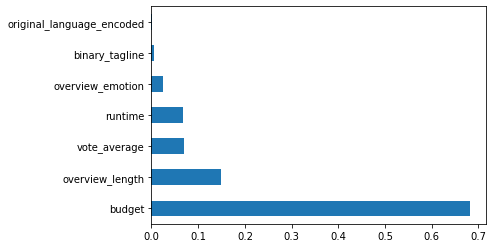

In [24]:
# Check feature importance - the budget is the most important feature in the model, with the overview_length second and the average vote for the movie third. 

feat_importances = pd.Series(dt_regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [25]:
#Testing Accuracy - on unseen data the model perform quite poorly - with an accuracy of 47%

y_pred = dt_regressor.predict(X_test)
r2_score(y_test, y_pred)

0.473838555356076

In [26]:
# Run performance metrics without hyperparameter tuning - they are all high, which is not good. For regression problems, a good model would have low error rates but this is not the case here. 
#It could be that more features are needed for the analysis to be more roboust.

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 11714966.100360576
MSE: 2169322645608084.5
RMSE: 46575987.86508005


### Hyperparameter Tunning

As the accuracy on unseen data was 47%, I am tuning to hyperamater tunning. For this I picked the grid search method because regression decision trees have many hyperparameters, and finding the optimal combination can be time-consuming and challenging manually. With grid search, we can automate the process and ensure that we are exploring the entire hyperparameter space, thus maximizing the chances of finding the best set of hyperparameters.  I am looking to improve 6 hyperparameters.
- max_depth: The maximum depth of the decision tree.
- max_features: The number of features to consider when looking for the best split.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- min_samples_split: The minimum number of samples required to split an internal node.
- criterion: The function used to measure the quality of a split.
- splitter: The strategy used to choose the split at each node.

In [27]:
# Hyper parameters range initialization for tuning
param_grid = {
    'max_depth': [80, 90, 100, None],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 4],
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'splitter': ["best", "random"]
}

# Create the decision tree regressor object 
dt_regressor = DecisionTreeRegressor(random_state = 0) #random_state of 0 so the analysis is reproducible

# Create the grid search object
grid_search = GridSearchCV(estimator = dt_regressor, param_grid = param_grid, cv = 10, verbose = 2, scoring = 'r2', n_jobs = -1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train);

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable T

In [28]:
# Get the best model from the grid search

best_model = grid_search.best_estimator_


#### Training Accuracy - The code is using the best model that was identified during the grid search to make predictions on the training set


In [29]:
# Use the best model to make predictions
y_pred = best_model.predict(X_train)

# Compute the R-squared score of the model on the training data - accuracy decreased from 100% to 74%
r2_score(y_train, y_pred)

0.7331952198272531

#### Testing Training Accuracy - The code sis using the best model obtained from a grid search to make predictions on the testing set and evaluating the model's performance using the R-squared score.


In [30]:
# Compute the R-squared score of the model on the testing data - accuracy increased from 47% to 60%

y_pred = best_model.predict(X_test)
r2_score(y_test, y_pred)

0.5943354135595633

#### Review Performance Metrics

In [31]:
# With hyperparameter tuned - even though the accuracy increased, the metrics are very high which means that the model is not roboust enough.

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 10354753.418038838
MSE: 1672523486554631.5
RMSE: 40896497.24065169


## Regression Decision Tree Results

The results show that the decision tree regressor model has a training accuracy of 100%, which suggests that it might have overfit the training data. However, the testing accuracy is only 48%, indicating that the model is not performing well on unseen data. To improve the model's performance, hyperparameter tuning is done using grid search with cross-validation. The best model from the grid search has a training accuracy of 74% and a testing accuracy of 60%, which suggests that the model has improved and can now generalize better to new data. Overall, the model can be used to predict the revenue of a movie based on its budget, runtime, vote average, overview length, binary tagline, original language, and the emotion of the movie overview, but further analysis is needed to determine if the model is suitable for practical use. The error rates suggest that the model is not very accurate in predicting the revenue of the movies. The mean absolute error (MAE) of 10,354,753 suggests that, on average, the model's revenue predictions are off by that amount ($). The mean squared error (MSE) and root mean squared error (RMSE) are also quite large, which further confirms that the model is not very accurate.

# Multiple Regression model - test out of using a multiple regression model improve the model accuracy 

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [33]:
# Define the features (X) and target (y)
X = movies_df[['budget','runtime', 'vote_average', 'overview_length', 'binary_tagline', 'original_language_encoded', 
               'overview_emotion']]

y = movies_df['revenue']

In [34]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# Create a pipeline with a StandardScaler and a LinearRegression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [38]:
# Fit the pipeline to the training data
lr_pipeline.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = lr_pipeline.predict(X_train)

# Print the evaluation metrics - based on the R2, the features explain 60% of the model, however the MSE and RMSE are high which indicates that the model is not accurate
print("R-squared:", r2_score(y_train, y_pred_train))
print("MSE:", mean_squared_error(y_train, y_pred_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))

R-squared: 0.5940834975170468
MSE: 1398341681255519.0
RMSE: 37394407.08522491


In [39]:
# Use the pipeline to make predictions on the test set
y_pred = lr_pipeline.predict(X_test)

# Print the evaluation metrics - based on the R2, the features explain 63% of the model, however the MSE and RMSE are high which indicates that the model is not accurate
print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.6263565115691124
MSE: 1540502994068033.2
RMSE: 39249241.955329955


### Hyperparameter Tunning

Tunning the regression hyperparameters:

- regressor__fit_intercept: This parameter controls whether or not to calculate the intercept for the linear regression model
- scaler__with_mean: This parameter controls whether or not to center the data before scaling for the standard scaler
- scaler__with_std: This parameter controls whether or not to scale the data to unit variance for the standard scaler

In [40]:
# Define the features (X) and target (y)
X = movies_df[['budget','runtime', 'vote_average', 'overview_length', 'binary_tagline', 'original_language_encoded', 
               'overview_emotion']]

y = movies_df['revenue']

In [41]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[CV] END criterion=poisson, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=poisson, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=poisson, max_depth=1

In [43]:
# Create a pipeline with a StandardScaler and a LinearRegression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [44]:
# Define the hyperparameter grid
param_grid = {
    'regressor__fit_intercept': [True, False],
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False]
}

In [45]:
# Create a grid search object
grid = GridSearchCV(lr_pipeline, param_grid=param_grid, scoring='r2', cv=5)


# Fit the grid search object to the training data
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]},
             scoring='r2')

In [46]:
# Print the best hyperparameters
print("Best hyperparameters: ", grid.best_params_)


Best hyperparameters:  {'regressor__fit_intercept': True, 'scaler__with_mean': True, 'scaler__with_std': True}


In [48]:
# Use the best model to make predictions on the test set
y_pred = grid.predict(X_test)

# Print the evaluation metrics - the R2 hasn't changed with the hyperparameter tunning which means that in this case the hyperarameter tunning didn't do much for the model.
print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.6263565115691124
MSE: 1540502994068033.2
RMSE: 39249241.955329955


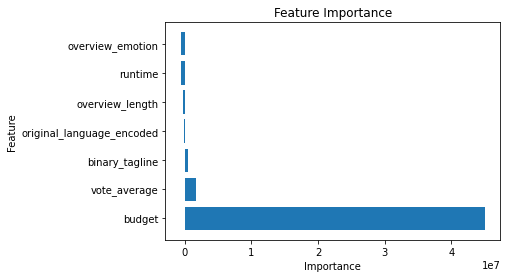

In [49]:
# Get the coefficients of the linear regression model
coefficients = grid.best_estimator_.named_steps['regressor'].coef_

# Create a dataframe of feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': coefficients})

# Sort the features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot the feature importance
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Multiple Regression Results

Based on the results, the multiple regression model has a training accuracy of 60% which is a positive result. However, the error rates of the MSE and RMSE are quite high, which indicates that important features might be missing from the analysis. To improve the accurate and the error rate, hyperparameter tunning was done using grid search. The results improved slightly, with an R-squared value of 0.627 on the test set, indicating that 63% of the variability in the revenue can be explained by the input features. The MSE of 1540502994068033.2 and the RMSE of 39249241.9 suggest that the model has a high prediction error, indicating that there may be additional important input features that were not included in the model or that the model may be overfitting the training data. 